Оператор мобильной связи «М-лайн» выяснил: многие клиенты пользуются архивными тарифами.
Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф:

«См» или «Ул».
В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»).

Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.
Постройте модель с максимально большим значением accuracy. 
Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте accuracy на тестовой выборке самостоятельно.
Инструкция по выполнению проекта
Откройте файл с данными и изучите его. Путь к файлу: /datasets/users_behavior.csv. Скачать датасет
Разделите исходные данные на обучающую, валидационную и тестовую выборки.
Исследуйте качество разных моделей, меняя гиперпараметры. Кратко напишите выводы исследования.
Проверьте качество модели на тестовой выборке.
Дополнительное задание: проверьте модели на вменяемость. Ничего страшного, если не получится: эти данные сложнее тех, с которыми вы работали раньше. В следующем курсе подробнее об этом расскажем.
Описание данных
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
сalls — количество звонков,
minutes — суммарная длительность звонков в минутах,
messages — количество sms-сообщений,
mb_used — израсходованный интернет-трафик в Мб,
is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

Импортируем необходимые библиотеки для работы:

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

[Дерево решений](#search_model)

[Случайный лес](#RandomForest)

[Логистическая регрессия](#log_reg)

[Проверьте модель на тестовой выборке](#res_test)

[Проверьте модели на адекватность](#test_adec)

In [5]:
try:
    df = pd.read_csv('C:\\Users\\radim\\Downloads\\users_behavior.csv')
except:
    df = pd.read_csv('users_behavior.csv')
    

In [6]:
df.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


• сalls — количество звонков,

• minutes — суммарная длительность звонков в минутах,

• messages — количество sms-сообщений,

• mb_used — израсходованный интернет-трафик в Мб,

• is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [8]:
print(f'Размерность датафрейма составляет:{df.shape}')

Размерность датафрейма составляет:(3214, 5)


In [9]:
print(f'Количество дубликатов составляет:{df.duplicated().sum()}')

Количество дубликатов составляет:0


Корректность названия столбцов:

In [10]:
df.columns

Index(['calls', 'minutes', 'messages', 'mb_used', 'is_ultra'], dtype='object')

Пропуски с помощью градиента:

In [11]:
pd.DataFrame(round(df.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
calls,0.000000
minutes,0.000000
messages,0.000000
mb_used,0.000000
is_ultra,0.000000


мы видим, что данные не нуждаются в дополнительной обработке, 
нет ни пропусков, ни дубликатов, типы данные соответствуют колонкам, столбцы названы корректно.

<div class="alert alert-success">




<div class="alert alert-warning">



проверить датасет на сбалансированность классов в таргете.  тут можно [почитать](https://dyakonov.org/2021/05/27/imbalance/) заранее зачем мы обращаем внимание на это.  [тут](https://habr.com/ru/post/349078/) так ли он страшен  ))




Можно посмотреть корреляцию признаков.что такое мультиколлинеарность, какие два типа проблем возникает, для каких моделей и какие варианты решения




</div>

In [12]:
smart = np.sum(df.is_ultra==0)
ultra = np.sum(df.is_ultra==1)
print(smart, ultra)

2229 985


<AxesSubplot:xlabel='is_ultra', ylabel='count'>

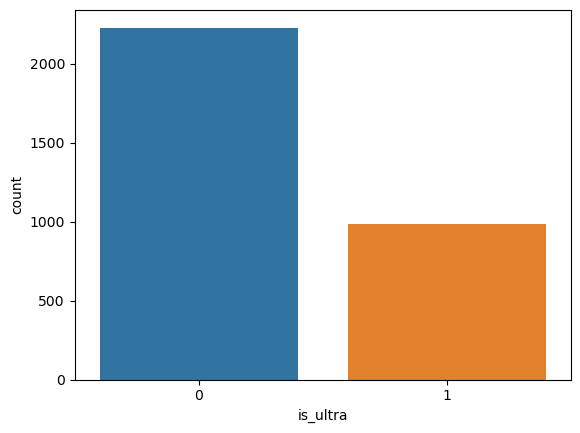

In [13]:
sns.countplot(x='is_ultra',data=df)

<AxesSubplot:>

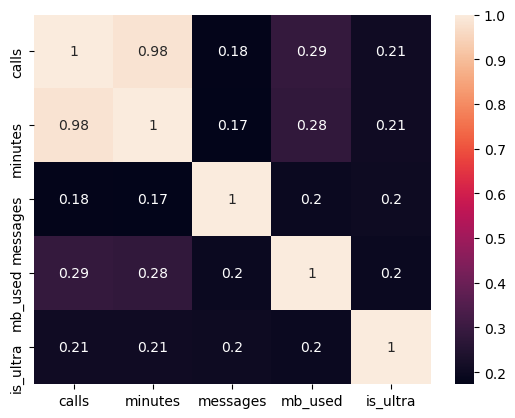

In [14]:
sns.heatmap(df.corr(),annot=True)

данные нужно разбить на три части: обучающую, валидационную и тестовую. 
Размеры тестового и валидационного наборов обычно равны. Исходные данные разбивают в соотношении 3:1:1.
Следовательно делим на 60%, 20% и 20%. отделим обучающую от тестовой.

In [15]:
df_train, df_test = train_test_split(df, test_size=0.4, random_state=12345, stratify=df['is_ultra'])
features = df_test.drop(['is_ultra'],axis=1)
target = df_test['is_ultra']

разобьём выборку на валидационную и тестовую,пополам, по 20%:

In [16]:
features_valid,features_test, target_valid, target_test\
    =train_test_split(features,target,test_size=0.5,random_state=12345,stratify=target)

In [17]:
features_train = df_train.drop(['is_ultra'],axis=1)
target_train = df_train['is_ultra']

In [18]:
#правильно ли выборки поделились :
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(1928, 4)
(643, 4)
(643, 4)


Данные разбиты на:

обучающую выборку - features_train, target_train

валидационную выборку - features_valid, target_valid

тестовую выборку - features_test, target_test

## Дерево решений.
<a id='search_model'></a>

In [19]:
%%time
best_model_tree = None
accuracy_tree = 0
best_depth_tree = 0
accuracy_list = []
max_depth_list = []
for depth in range(1,20):
    model_tree = DecisionTreeClassifier(random_state=42,max_depth=depth)
    model_tree.fit(features_train,target_train)
    predictions_valid = model_tree.predict(features_valid)
    accuracy = accuracy_score(target_valid,predictions_valid)
    accuracy_list.append(accuracy)
    max_depth_list.append(depth)
    if accuracy>accuracy_tree:
        best_model_tree = model_tree
        accuracy_tree = accuracy
        best_depth_tree = depth

Wall time: 198 ms


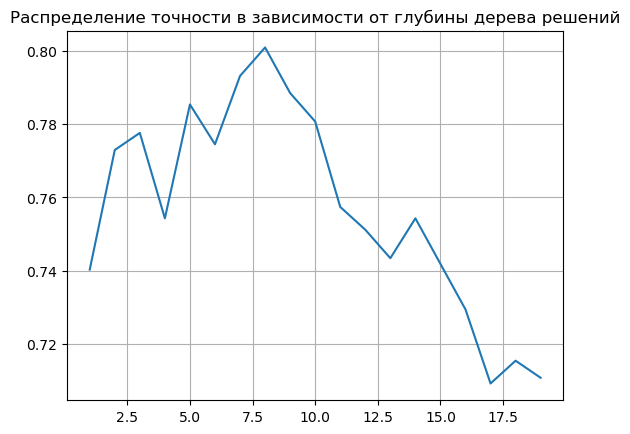

Наилучшая точность DecisionTreeClassifier на валидационной выборке составила: 0.8009331259720062
При глубине дерева равной: 8


In [20]:
plt.plot(max_depth_list,accuracy_list)
plt.title('Распределение точности в зависимости от глубины дерева решений')
plt.grid()
plt.show()
print(f"Наилучшая точность DecisionTreeClassifier на валидационной выборке составила: {accuracy_tree}")
print(f"При глубине дерева равной: { best_depth_tree}")

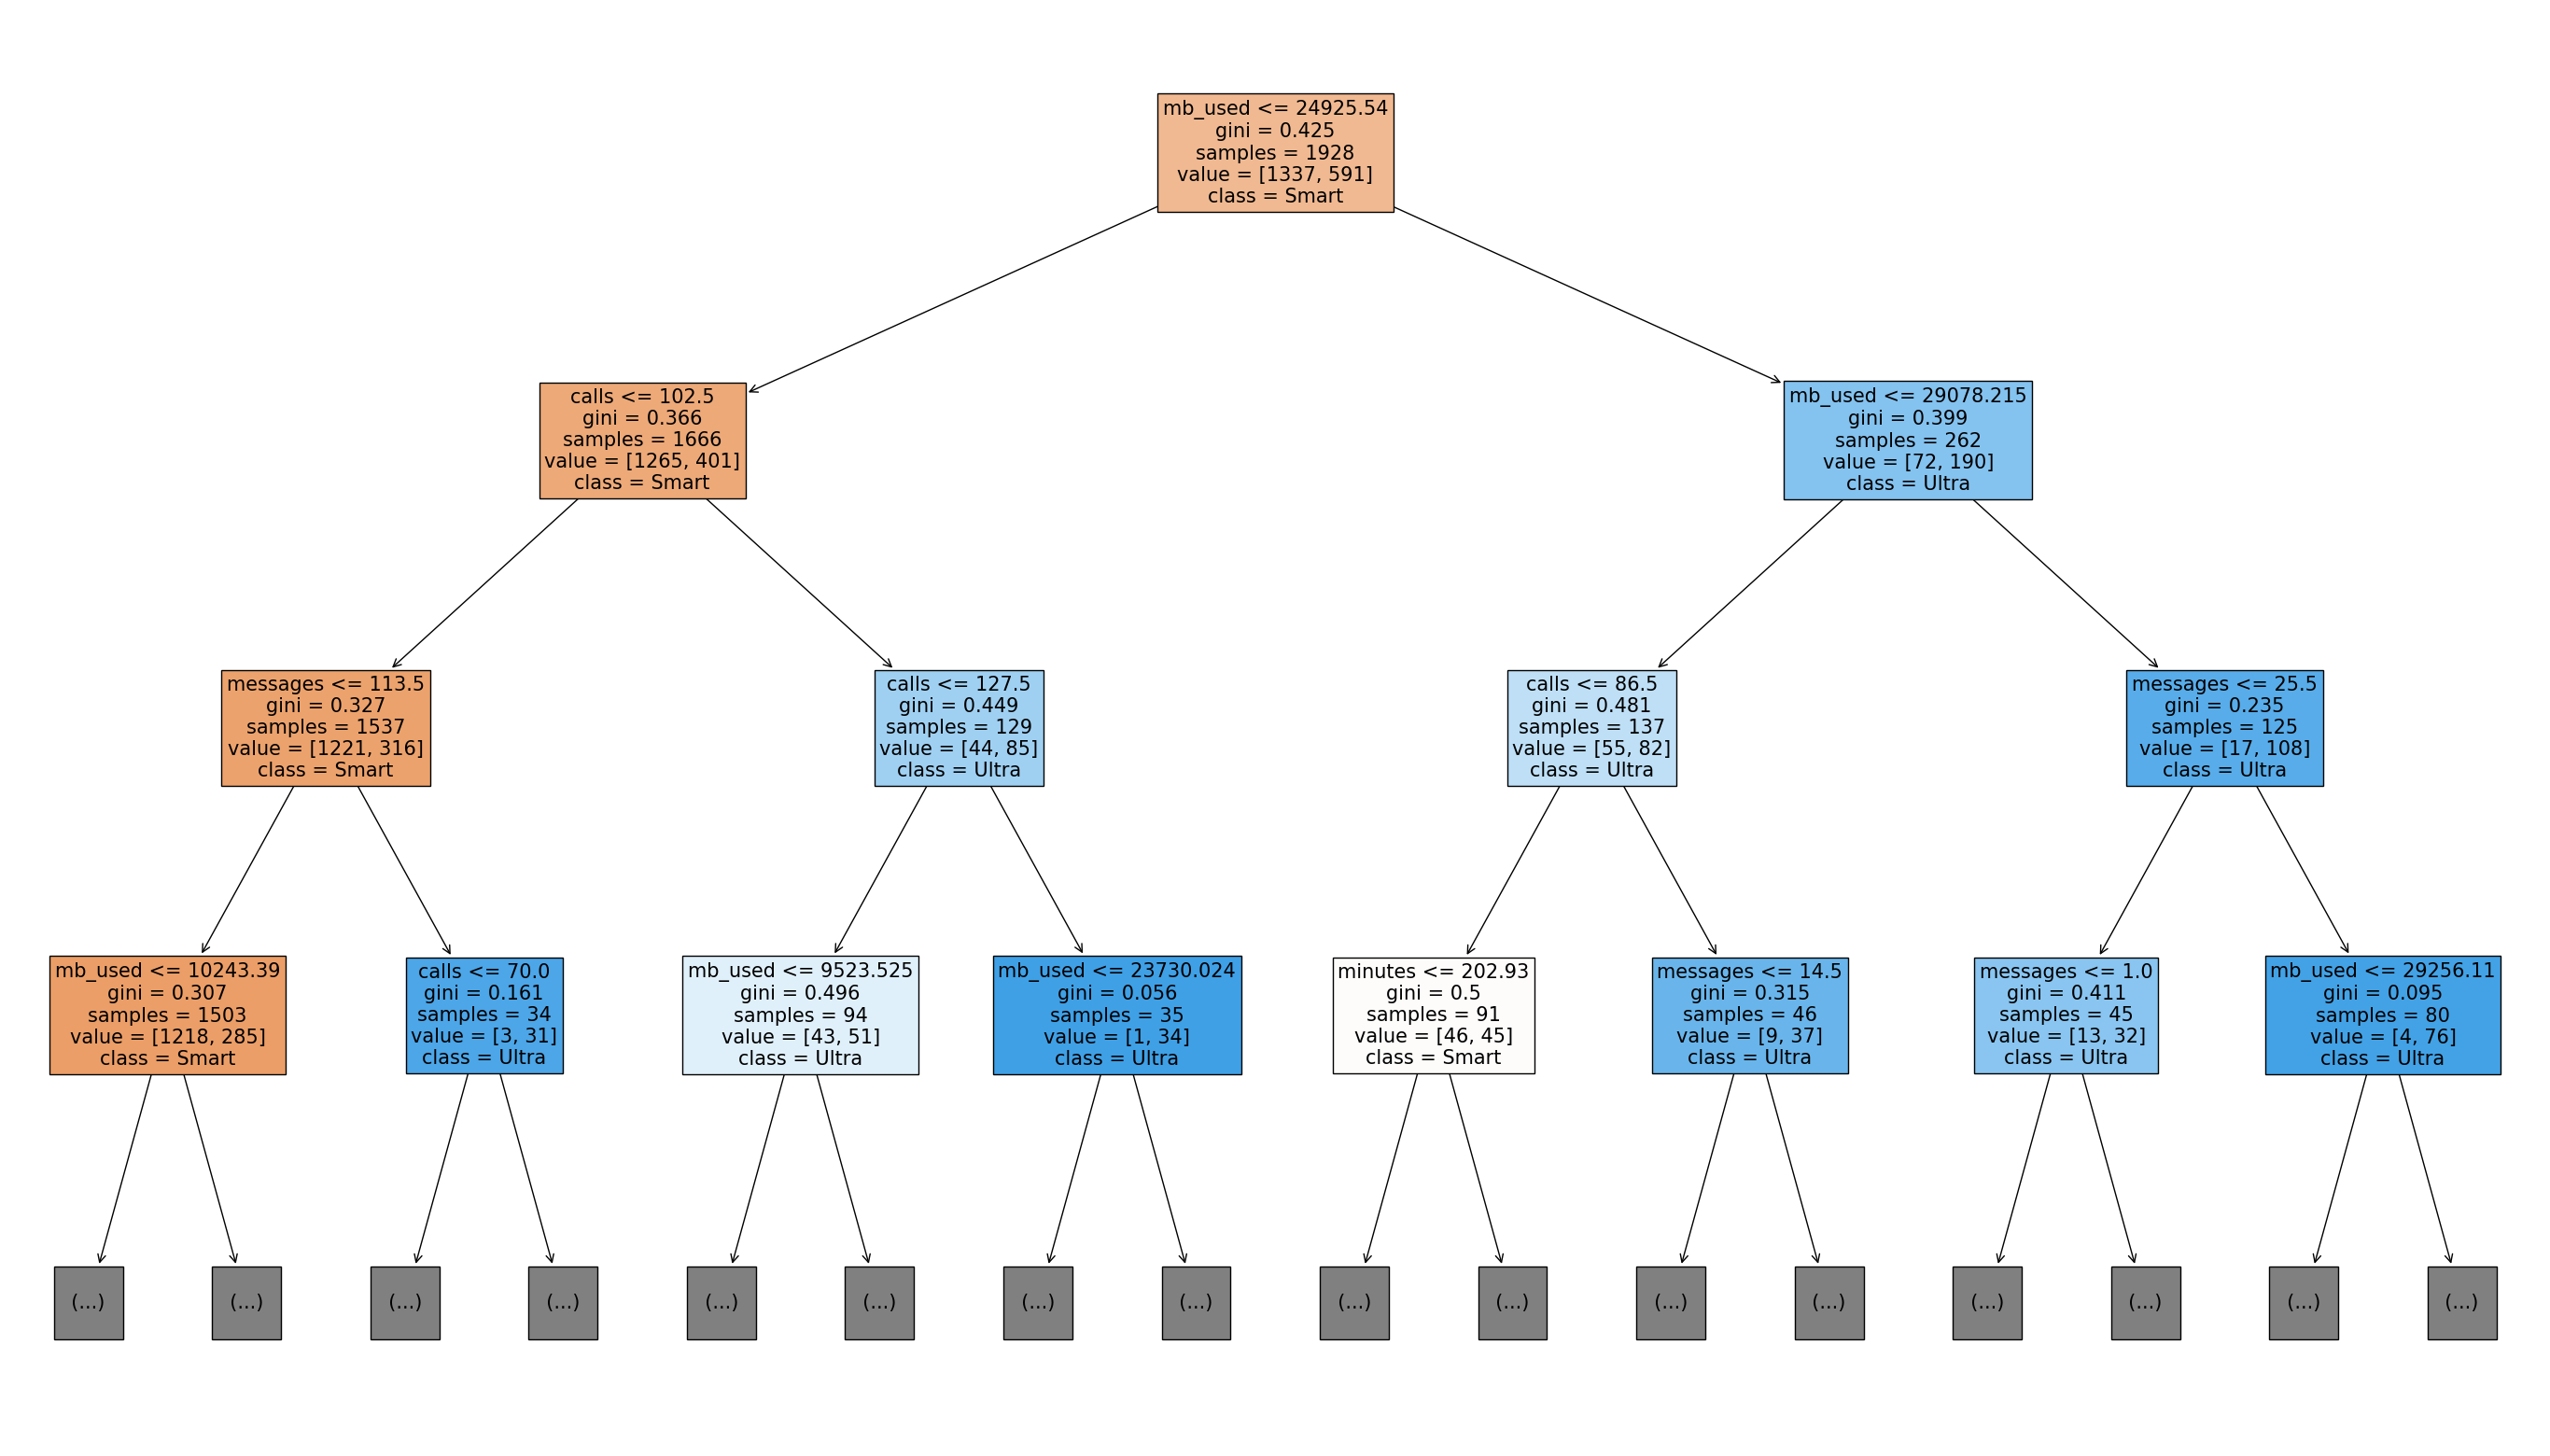

In [21]:
fig = plt.figure(figsize=(35,20))
_ = tree.plot_tree(best_model_tree, 
               feature_names=features.columns.values, 
               class_names=['Smart','Ultra'],
               filled=True,
               fontsize = 15,
               max_depth = 3     # Это чтобы прорисовывало 3 уровня, не глубже
                  )


На графике можно посмотреть как при изменении гиперпараметров меняется точность на train и validation датасете (для этого собираем наши метрики на валидации и train в списки, а затем по ним обычный plt.plot()).Этот способ используют для отслеживания переобучения, но для этого стоит взять пернебор по max_depth глубже.
tree_plot можно строить, с max_depth равной 3(глубже будет громоздко) посмотреть как DT сплиты делает, это даёт понимание как модель принимает решения: какие признаки использует, на каких значениях делает разбиение вправо - влево

## Случайный лес
<a id='RandomForest'></a>

Глубину возьмём в диапазоне от 1-10, а количество деревьев - от 1 до 20

In [22]:
%%time
best_model_forest = None
accuracy_forest = 0
best_est_forest = 0
best_depth = 0
for depth in range(1,11):
    for est in range(1,20):
        model_forest = RandomForestClassifier(random_state=42,n_estimators=est,max_depth=depth)
        model_forest.fit(features_train,target_train)
        predictions_valid = model_forest.predict(features_valid)
        accuracy = accuracy_score(target_valid,predictions_valid)
        if accuracy>accuracy_forest:
            best_model_forest = model_forest
            accuracy_forest = accuracy
            best_est_forest = est
            best_depth_forest = depth


Wall time: 7.49 s


In [24]:
print(f"Наилучшая точность модели RandomForestClassifier на валидационной выборке составила: {accuracy_forest}")
print( f"При количестве деревьев: {best_est_forest}", f"И максимальной глубине: {depth}")

Наилучшая точность модели RandomForestClassifier на валидационной выборке составила: 0.8149300155520995
При количестве деревьев: 10 И максимальной глубине: 10


Изучить sklearn-ий GreedSearchCV. При использования GridSearch, не нужно  заранее делать валидационную выборку, лучшую метрика сохраняется в best_score_, а лучшая модель (переобученная уже на полном наборе данных) будет храниться в best_estimator_

<div class="alert alert-warning">
<font size="5"><b>Комментарий</b></font>

Как запросто "войти в тему":

1.  Идём в туториал, копируем пример:
    
    
    from sklearn import svm, datasets
    from sklearn.model_selection import GridSearchCV
    iris = datasets.load_iris()
    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
    svc = svm.SVC()
    clf = GridSearchCV(svc, parameters)
    clf.fit(iris.data, iris.target)


    sorted(clf.cv_results_.keys())
    
    
2. Меняем:    
    
    
    
    iris.data  ------ > на свои фичи  (обьеденив через pd.concat свой train и validation, ведь валидационный датасет GS делает сам)  
    iris.target -------> на своий таргет
    
    меняем(модель если хочешь не SVM)        
    
    меняешь {'kernel':('linear', 'rbf'), 'C':[1, 10]} на свой набор перебираемых параметров
    
    
        
3. После обучения смотрим    clf.best_score_ - это оценка на валидации лучшей модели которую GS нашел в цикле внутри себя, а чтобы прогнозировать этой моделью используем clf.best_estimator_. Можно посмотреть какие лучшие гиперпараметры нашел GS смотришь clf.best_params_. 
    
    


    
</div>

## Логистическая регрессия
<a id='log_reg'></a>

In [31]:
model_logistic = LogisticRegression(random_state=42,solver='lbfgs')
model_logistic.fit(features_train,target_train)
predictions_logistic = model_logistic.predict(features_valid)
accuracy_logistic = accuracy_score(target_valid,predictions_logistic)

print(f"Точность модели LogisticRegression на валидационной выборке составила:  {accuracy_logistic}")

Точность модели LogisticRegression на валидационной выборке составила:  0.7387247278382582


In [32]:
print(f'Петрое место занимает случайный лес:  {accuracy_forest}')
print(f'Второе место занимает дерево решений:  {accuracy_tree}')
print(f'Третье место занимает логистическая регрессия:  {accuracy_logistic}')

Петрое место занимает случайный лес:  0.8149300155520995
Второе место занимает дерево решений:  0.8009331259720062
Третье место занимает логистическая регрессия:  0.7387247278382582


Вывод:

В данном пункте были найдены оптимальные параметры трех моделей на валидационной выборке и посчитана их точность:

Наилучшая точность DecisionTreeClassifier на валидационной выборке составила: ≈ 0.8025 При глубине дерева: 8
Наилучшая точность модели RandomForestClassifier на валидационной выборке составила: ≈ 0.8243. При количестве деревьев: 60 И максимальной глубине: 14
Точность модели LogisticRegression на валидационной выборке составила: ≈ 0.7387


Исходя из полученных результатов сделаем вывод, что самая оптимальная модель "Случайного леса", точность составила ≈ 0.8243

## Проверьте модель на тестовой выборке
<a id='res_test'></a>

In [44]:
model = RandomForestClassifier(max_depth=12,n_estimators=60,random_state=42)
model.fit(features_train,target_train)
accuracy_forest_test = model.score(features_test,target_test)

print("Качество:", accuracy_forest_test)

Качество: 0.8102643856920684


## Проверьте модели на адекватность
<a id='test_adec'></a>

In [48]:
random_answers = np.random.randint(0, 2, size = 643)
accuracy_random_test = round(accuracy_score(target_test, random_answers), 4)
print("Качество прогноза случайных чисел:", accuracy_random_test)
print("Качество нашего прогноза :", accuracy_forest_test)

Качество прогноза случайных чисел: 0.4899
Качество нашего прогноза : 0.8102643856920684
